# Protocol 2: Assessing cell type replicability against a pre-trained reference taxonomy

Protocol 2 demonstrates how to assess cell types of a newly annotated dataset against a reference cell type taxonomy. Here we consider the cell type taxonomy established by the Brain Initiative Cell Census Network (BICCN) in the mouse primary motor cortex. The BICCN taxonomy was defined across a compendium of datasets sampling across multiple modalities (transcriptomics and epigenomics), it constitutes one of the richest neuronal resources currently available. When matching against a reference taxonomy, we assume that the reference is of higher resolution than the query dataset, i.e. the query dataset samples the same set or a
subset of cells compared to the reference.

## Step 1 - Pre-train a reference MetaNeighbor model.

1. We start by importing utility packages and setting up the default behavior for plots.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pymn
import re

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

2. We load an already merged Anndata object containing the BICCN dataset. The full code for generating the dataset is available [here](https://github.com/gillislab/pyMN/blob/master/data/biccn.py), the dataset itself can be downloaded directly from Figshare using the link below.

In [5]:
!curl -L -o biccn_hvg.h5ad https://ndownloader.figshare.com/files/24928559

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  117M  100  117M    0     0  3021k      0  0:00:39  0:00:39 --:--:-- 4018k


In [6]:
adata = sc.read_h5ad('biccn_hvg.h5ad')

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
adata.obs.columns = adata.obs.columns.astype(str)

The BICCN data contains 7 datasets totaling 482,712 cells. There are multiple sets of cell type labels depending on resolution (class, subclass, cluster) or type of labels (independent labels or labels defined from joint clustering). Note that, to reduce memory usage, we have already computed and restricted the dataset to a set of 319 highly variable genes.

3. We create pre-trained models with the *trainModel* function, which has identical parameters as the *MetaNeighborUS* function. Here, we choose to focus on two sets of cell types: subclasses from the joint clustering (medium resolution, e.g., Vip interneurons, L2/3 IT excitatory neurons), and clusters from the joint clustering (high resolution, e.g., Chandelier cells).

Since the dataset has already been subsetted to the highly variable genes we can make a column of all Trues under `.var['highly_variable']`

In [8]:
adata.var['highly_variable'] = True

In [9]:
ptrained_subclass = pymn.trainModel(adata, 'study_id', 'joint_subclass_label')
ptrained_subclass.to_csv('pretrained_biccn_subclasses.csv')

ptrained_cluster = pymn.trainModel(adata, 'study_id', 'joint_cluster_label')
ptrained_cluster.to_csv('pretrained_biccn_clusters.csv')

For simplicity of use, we store the pretrained models to file using the "write_csv" function in pandas.

## Step 2 - Compare annotations to pre-trained taxonomy

4. We start by loading our query dataset (Tasic 2016, neurons from mouse primary visual cortex, available for download using curl) and our pre-trained subclass and cluster taxonomies.

> Tasic data was aquired using the R scRNAseq package. You can see the code for aquiring and processing the data using a combination of these two [R](https://github.com/gillislab/pyMN/blob/master/data/tasic.R) and [python](https://github.com/gillislab/pyMN/blob/master/data/tasic.py) scripts

In [10]:
!curl -L -o tasic.h5ad https://ndownloader.figshare.com/files/24928580

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 55.2M  100 55.2M    0     0  2686k      0  0:00:21  0:00:21 --:--:-- 2897k


In [11]:
tasic = sc.read_h5ad('tasic.h5ad')
tasic.obs.columns = tasic.obs.columns.astype(str)

biccn_subclasses = pd.read_csv('pretrained_biccn_subclasses.csv', index_col=0)
biccn_clusters = pd.read_csv('pretrained_biccn_clusters.csv', index_col=0)

Note that we add a "study_id" column to the Tasic metadata, as this information will be needed later by MetaNeighbor.

4. To run MetaNeighbor, we use the "MetaNeighborUS" function but, compared to Protocol 1, we provide a pre-trained model instead of a set of highly variable genes (which are already contained in the pre-trained model). We start by checking if Tasic cell types are consistent with the BICCN subclass resolution.

In [17]:
pymn.MetaNeighborUS(tasic,
                    'study_id',
                    'primary_type',
                    trained_model=biccn_subclasses, 
                    symmetric_output=False)

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/pymn/utils.py:98: UserWarning: Replacing any | with a . in study column values
  warnings.warn("Replacing any | with a . in study column values")


5. We visualize AUROCs as a rectangular heatmap, with the reference taxonomy as columns and query cell types as rows.

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


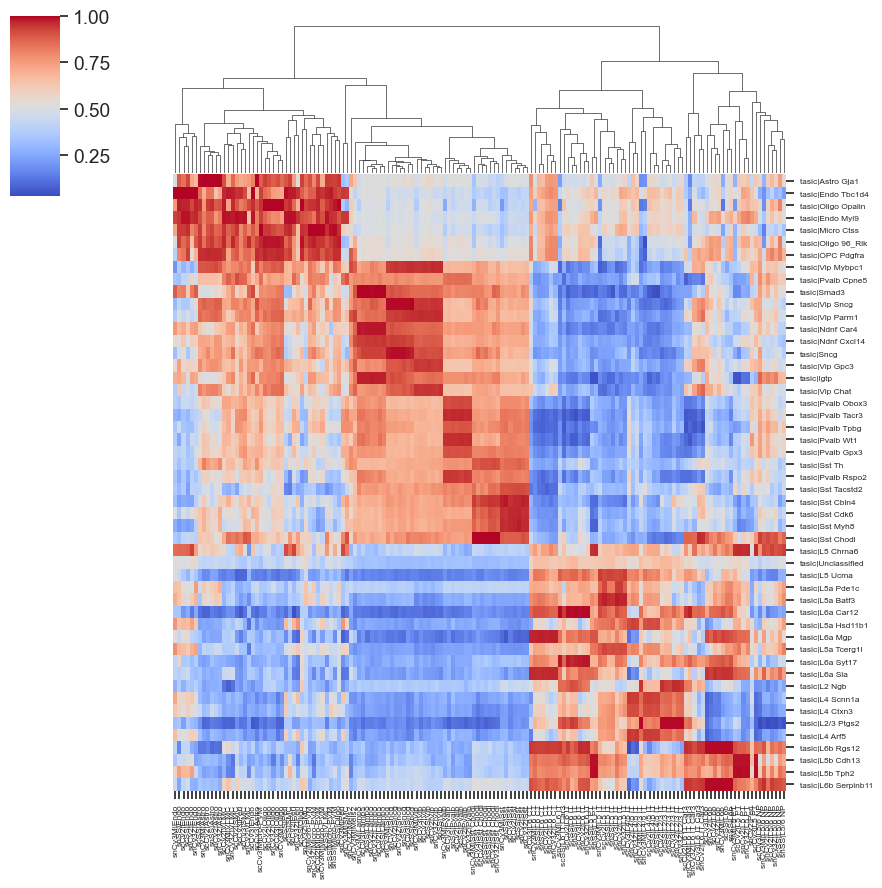

In [18]:
pymn.plotMetaNeighborUS_pretrained(tasic,
                                   cmap='coolwarm',
                                   figsize=(10, 10),
                                   fontsize=6,
                                   xticklabels=True,
                                   yticklabels=True)

As in Protocol 1, we start by looking for evidence of global structure in the dataset. Here we recognize 3 red blocks, which correspond to non-neurons (top left), inhibitory neurons (middle) and excitatory neurons (bottom right). The presence of sub-blocks inside the 3 global blocks suggest that cell types can be matched more finely. For example, inside the inhibitory block, we can recognize sub-blocks corresponding to CGE- derived interneurons (Vip, Sncg and Lamp5 in the BICCN taxonomy) and MGE-derived interneurons (Pvalb
and Sst in the BICCN taxonomy).

6. We refine AUROCs by focusing on inhibitory neurons. We use two utility functions ("splitTrainClusters" and "splitTestClusters") to select the relevant cell types.

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/pymn/utils.py:98: UserWarning: Replacing any | with a . in study column values
  warnings.warn("Replacing any | with a . in study column values")
/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


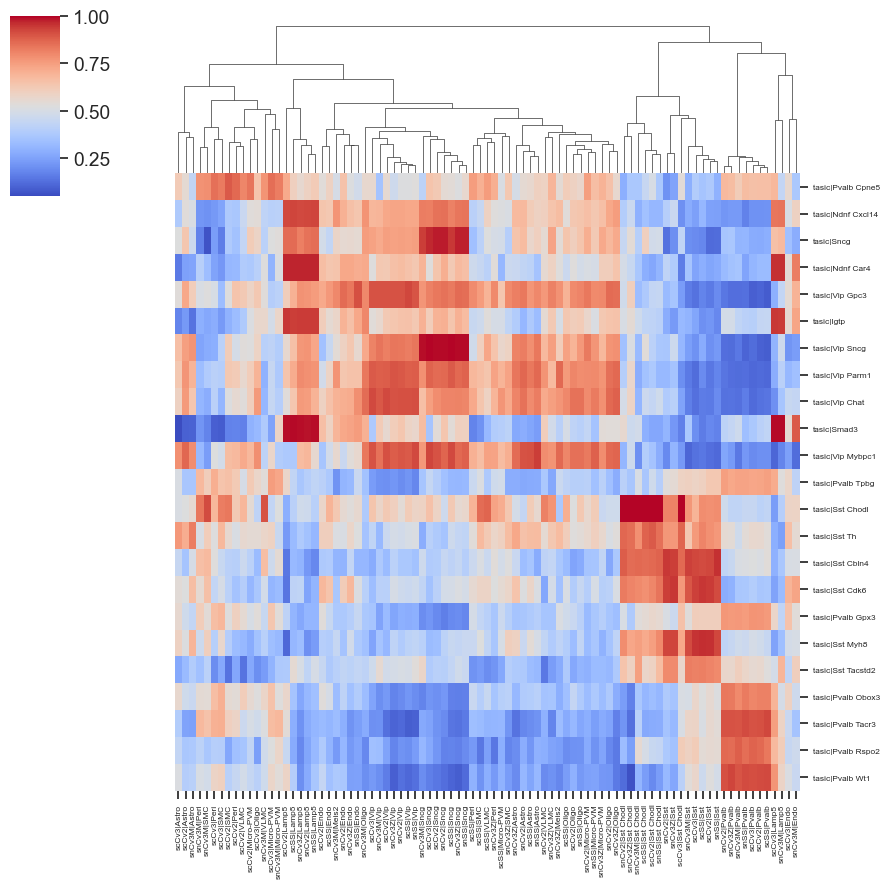

In [19]:
gabaergic_biccn = pymn.splitTestClusters(tasic, k=4, save_uns=False)[0]
gabaergic_tasic = pymn.splitTrainClusters(tasic, k=4, save_uns=False)[1]

keep_cells = np.in1d(
    pymn.join_labels(tasic.obs['study_id'], tasic.obs['primary_type']),
    gabaergic_tasic)

tasic_subset = tasic[keep_cells]

pymn.MetaNeighborUS(tasic_subset,
                    'study_id',
                    'primary_type',
                    trained_model=biccn_subclasses[gabaergic_biccn], 
                    symmetric_output=False)

pymn.plotMetaNeighborUS_pretrained(tasic_subset,
                                   cmap='coolwarm',
                                   xticklabels=True,
                                   yticklabels=True,
                                   figsize=(10, 10))

The heatmap suggests that there is a broad agreement at the subclass level between the BICCN MOp taxonomy and the Tasic 2016 dataset. For example, the Ndnf subtypes, Igtp and Smad3 cell types from the Tasic dataset match with the BICCN Lamp5 subclass.

7. The previous heatmaps suggest that all Tasic cell types can be matched with one BICCN subclass. We now go one step further and ask whether inhibitory cell types correspond to one of the BICCN clusters.

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/pymn/utils.py:98: UserWarning: Replacing any | with a . in study column values
  warnings.warn("Replacing any | with a . in study column values")
/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


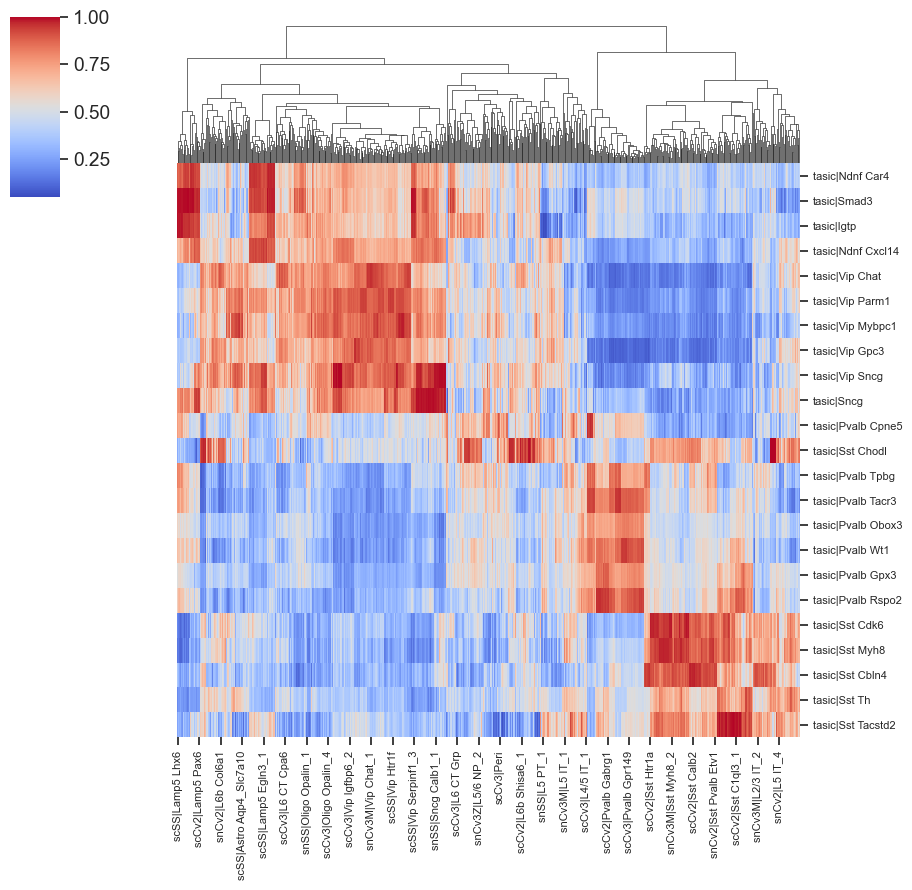

In [20]:
pymn.MetaNeighborUS(tasic_subset,
                    'study_id',
                    'primary_type',
                    trained_model=biccn_clusters, 
                    symmetric_output=False)
pymn.plotMetaNeighborUS_pretrained(tasic_subset,
                                   cmap='coolwarm',
                                   figsize=(10, 10),
                                   fontsize=8)

Here the heatmap is difficult to interpret due to the large number of BICCN cell types (output omitted here). Because there is a limited number of cell types in the query dataset, we directly investigate the top hits for each query cell type.

In [21]:
result = tasic_subset.uns['MetaNeighborUS']
result.loc["tasic|Sst Chodl",].sort_values(ascending=False).head(10)


snCv3M|Sst Chodl    1.000000
snCv2|Sst Chodl     1.000000
scSS|Sst Chodl      1.000000
snCv3Z|Sst Chodl    1.000000
scCv2|Sst Chodl     1.000000
snSS|Sst Chodl      1.000000
scCv3|Sst Chodl     0.999966
scSS|L6b Ror1       0.990278
scCv3|L6b Ror1      0.988991
snCv3M|L6b Ror1     0.986450
Name: tasic|Sst Chodl, dtype: float64

In [22]:
result.loc["tasic|Pvalb Cpne5",].sort_values(ascending=False).head(10)

snCv2|Pvalb Vipr2_2     0.965672
scSS|Pvalb Vipr2_2      0.964620
scCv2|Pvalb Vipr2_2     0.963855
snCv3Z|Pvalb Vipr2_2    0.954963
scCv3|Pvalb Vipr2_2     0.950182
snSS|Pvalb Vipr2_2      0.942915
snCv3M|Pvalb Vipr2_2    0.930197
scCv2|SMC               0.905336
snCv3Z|L4/5 IT_2        0.875311
snCv3M|VLMC_6           0.856569
Name: tasic|Pvalb Cpne5, dtype: float64

We note two properties of matching against a pre-trained reference. First, replicable cell types have a clear top match in each of the reference dataset. Sst Chodl (long-projecting interneurons) match to similarly named clusters in the BICCN with an AUROC > 0.9999, Pvalb Cpne5 (Chandelier cells) match with the Pvalb Vipr2_2 cluster with AUROC > 0.93. Second, we have to be beware of false positives. For example, Sst Chodl secondarily matches with the L6b Ror1 cell types with AUROC > 0.98, an excitatory cell type only distantly related with long-projecting interneurons. When we use a pre-trained model, we only compute AUROCs with the reference data as the train data, so we cannot identify reciprocal hits. If we had been able to use “Tasic|Sst Chodl” as the training cluster, its votes would have gone heavily in favor of the BICCN’s Sst Chodl, making L6b Ror1 a low AUROC match on average. Because of the low dimensionality of gene expression space, we expect false positive hits to occur just by chance (e.g., cell types reusing similar pathways) when a cell type is missing in the query dataset. Here L6b Ror1 (an excitatory type) had no natural match with the Tasic inhibitory cell types and voted for its closest match, long-projecting interneurons.

There are three alternatives to separate true hits from false positive hits. First, if a cell type is highly replicable, it will have a clear top matching cluster in the reference dataset. Second, if the query dataset is known to be a particular subset of the reference dataset (e.g., inhibitory neurons, as is the case here), we recommend restricting the reference taxonomy to that subset. Third, if the first two solutions don’t yield clear results or cannot be performed, it is possible to go back to reciprocal testing by using the full BICCN dataset instead of the pre-trained reference.

We illustrate the first solution in the case of Chandelier cells.

In [23]:
get_cell_type = np.vectorize(lambda x: x.split('|')[1])

/var/folders/jk/q1h6l4q15ldb_bc_c54zy9l00000gn/T/ipykernel_73582/3377388747.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(np.log10(hits))


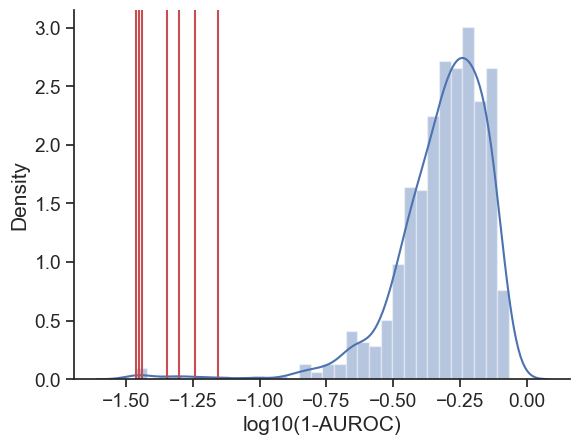

In [24]:
chodl_hits = result.loc["tasic|Pvalb Cpne5"]

is_chodl = get_cell_type(chodl_hits.index) == 'Pvalb Vipr2_2'

hits = 1 - chodl_hits
hits[hits == 0] = np.min(hits[hits != 0])

if sns.__version__ == '0.11.0':  #Highly reccomned upgrading to 0.11.0
    ax = sns.histplot(np.log10(hits))
else:
    ax = sns.distplot(np.log10(hits))
for val in np.log10(hits[is_chodl]):
    ax.axvline(val, c='r')
ax.set(xlabel='log10(1-AUROC)')
plt.show()

To illustrate AUROC differences, we chose a logarithmic scaling to reflect that AUROC values do not scale linearly: when AUROCs are close to 1, a difference of 0.05 is substantial. Here, the best matching BICCN cluster (“Pvalb Vipr2_2”) is order of magnitudes better than other clusters, suggesting very strong replicability.

9. The second solution to avoid false positive hits is to subset the reference to cell types that reflect the composition of the query datasets. Since we are looking at inhibitory neurons, we can restrict the BICCN taxonomy to inhibitory cell types, which names all start with “Pvalb”, “Sst”, “Lamp5”, “Vip” or “Sncg”.

In [25]:
find_gaba = re.compile("^(Pvalb|Sst|Lamp5|Vip|Sncg)")
get_gaba = np.vectorize(lambda x: find_gaba.search(x))

is_gaba = get_gaba(get_cell_type(biccn_clusters.columns)) != None
biccn_gaba = biccn_clusters.loc[:, is_gaba]
biccn_gaba_res = pymn.MetaNeighborUS(tasic_subset,
                                     'study_id',
                                     'primary_type',
                                     trained_model=biccn_gaba,
                                     save_uns=False, 
                                     symmetric_output=False)
biccn_gaba_res.loc["tasic|Sst Chodl"].sort_values(ascending=False).head(10)


/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/pymn/utils.py:98: UserWarning: Replacing any | with a . in study column values
  warnings.warn("Replacing any | with a . in study column values")


snSS|Sst Chodl      1.000000
snCv3M|Sst Chodl    1.000000
snCv2|Sst Chodl     1.000000
scCv2|Sst Chodl     1.000000
snCv3Z|Sst Chodl    1.000000
scCv3|Sst Chodl     1.000000
scSS|Sst Chodl      1.000000
snCv3M|Sst Pappa    0.888144
snCv2|Sst Th_3      0.874119
snCv3Z|Sst Calb2    0.868259
Name: tasic|Sst Chodl, dtype: float64

In [26]:
biccn_gaba_res.loc["tasic|Pvalb Cpne5"].sort_values(ascending=False).head(10)

snCv3M|Pvalb Vipr2_2    0.998948
snCv3Z|Pvalb Vipr2_2    0.998853
snCv2|Pvalb Vipr2_2     0.995506
scSS|Pvalb Vipr2_2      0.995028
snSS|Pvalb Vipr2_2      0.994645
scCv2|Pvalb Vipr2_2     0.993880
scCv3|Pvalb Vipr2_2     0.978390
snCv3M|Pvalb Vipr2_1    0.932014
scSS|Lamp5 Lhx6         0.883343
snSS|Lamp5 Lhx6         0.878944
Name: tasic|Pvalb Cpne5, dtype: float64

Again, we note that there is a significant gap between the best hit and the secondary hit, but now secondary hits are closely related cell types (Sst subtype for Sst Chodl, secondary Chandelier cell type Pvalb Vipr2_1 for Pvalb Cpne5).

10. To obtain a more stringent mapping between the query cell types and reference cell types, we use one-vs-best AUROC, which will automatically match the best hit against the best secondary hit.

/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/pymn/utils.py:98: UserWarning: Replacing any | with a . in study column values
  warnings.warn("Replacing any | with a . in study column values")
/Users/leon/miniconda3/envs/BICAN_mouse/lib/python3.9/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


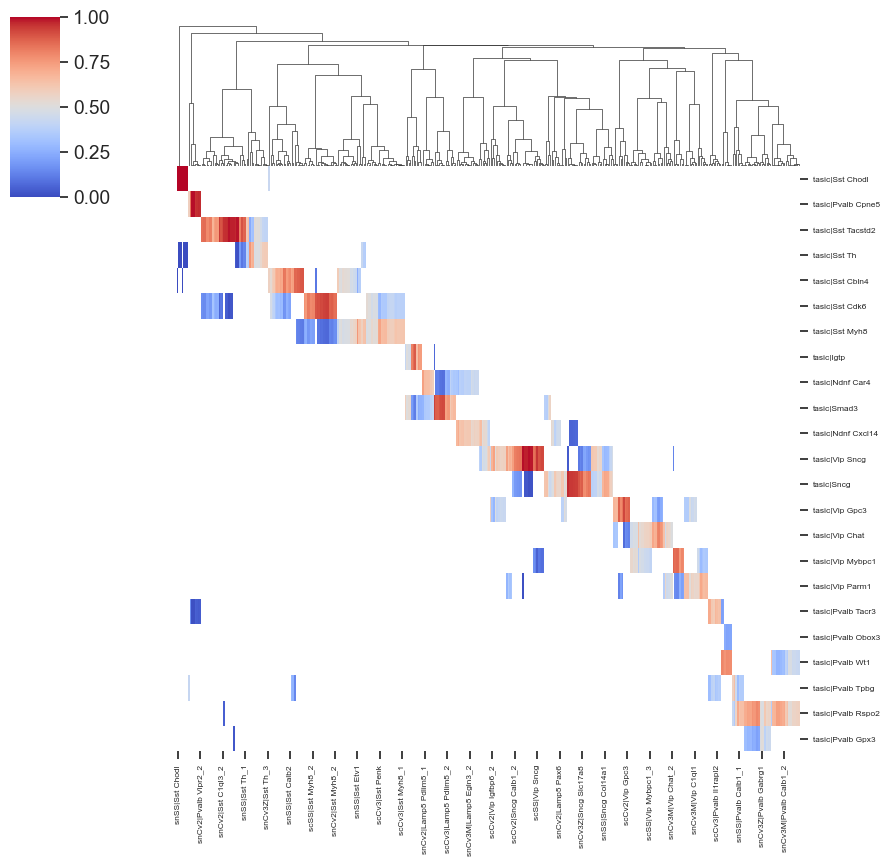

In [27]:
pymn.MetaNeighborUS(tasic_subset,
                    'study_id',
                    'primary_type',
                    trained_model=biccn_gaba,
                    fast_version=True,
                    one_vs_best=True,
                    symmetric_output=False)
pymn.plotMetaNeighborUS_pretrained(tasic_subset,
                                   cmap='coolwarm',
                                   mn_key='MetaNeighborUS_1v1',
                                   figsize=(10, 10))

Now the hit structure is much sparser, which helps identify 1:1 and 1:n hits. The heatmap suggests that most Tasic cell types match with one or several BICCN clusters, which we can further inspect by looking at top hits.

In [28]:
best_hits = tasic_subset.uns['MetaNeighborUS_1v1']
best_hits.loc["tasic|Sst Chodl"].sort_values(ascending=False).head(10)


scCv2|Sst Chodl        1.000000
scCv3|Sst Chodl        1.000000
scSS|Sst Chodl         1.000000
snCv2|Sst Chodl        1.000000
snCv3M|Sst Chodl       1.000000
snCv3Z|Sst Chodl       1.000000
snSS|Sst Chodl         1.000000
snCv3M|Sst Pappa       0.427905
scCv2|Lamp5 Egln3_1         NaN
scCv2|Lamp5 Egln3_2         NaN
Name: tasic|Sst Chodl, dtype: float64

In [29]:
best_hits.loc["tasic|Pvalb Cpne5",].sort_values(ascending=False).head(10)

snCv3M|Pvalb Vipr2_2    0.990946
snCv3Z|Pvalb Vipr2_2    0.989940
scSS|Pvalb Vipr2_2      0.966801
snCv2|Pvalb Vipr2_2     0.964789
snSS|Pvalb Vipr2_2      0.959759
scCv2|Pvalb Vipr2_2     0.951710
scCv3|Pvalb Vipr2_2     0.834004
snCv3M|Pvalb Vipr2_1    0.579365
scCv2|Lamp5 Egln3_1          NaN
scCv2|Lamp5 Egln3_2          NaN
Name: tasic|Pvalb Cpne5, dtype: float64

In [30]:
best_hits.loc["tasic|Sst Tacstd2",].sort_values(ascending=False).head(10)

snCv3M|Sst C1ql3_1    0.984962
snCv3Z|Sst C1ql3_1    0.984962
snCv2|Sst C1ql3_1     0.984962
scCv2|Sst C1ql3_1     0.973923
scSS|Sst C1ql3_1      0.973684
snSS|Sst C1ql3_2      0.973684
snSS|Sst C1ql3_1      0.966165
scCv3|Sst C1ql3_2     0.962406
scCv2|Sst C1ql3_2     0.958647
scCv3|Sst C1ql3_1     0.956221
Name: tasic|Sst Tacstd2, dtype: float64

Using this more stringent assessment, we confirm that Sst Chodl strongly replicates inside the BICCN (one-vs-best AUROC ~ 1, best secondary hit = 0.43), same for Pvalb Cpne5 (one-vs-best AUROC > 0.83, best secondary hit = 0.58), while for example Sst Tacstd2 corresponds to multiple BICCN subtypes (including
Sst C1ql3_1, Sst C1ql3_2, AUROC > 0.95).

Pre-training a MetaNeighbor model thus provides a rigorous, fast and simple way to query a large reference dataset and obtain quantitative estimations of the replicability of newly annotated clusters.